<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/07-bis-etiquetado_manual%2Bbeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de votación (LR+SS3+TFIDF) + BETO

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con todas las estrategias + la construcción de un clasificador con SVM.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

!pip install simpletransformers


### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df, separar_x_y_rna

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos, preprocesar_correos_bert

### 1.3. Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'correos-train-jaiio-80.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


In [5]:
train_df = train_df[['consulta', 'clase']]
train_df.columns = ['text', 'labels']
test_df = test_df[['consulta', 'clase']]
test_df.columns = ['text', 'labels']

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.labels.unique()), train_df.labels.unique()))

Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


In [6]:
from sklearn import preprocessing

le_clase = preprocessing.LabelEncoder()
train_df['labels'] = le_clase.fit_transform(train_df['labels'])

train_df.head()

,text,labels
0,quería saber por qué no puedo acceder al bolet...,0
1,no puedo reseterar mi clave de acceso al siste...,11
2,me dice que ya tengo el beneficio de la sube y...,0
3,"buenos días, quería consultar cuando me puedo ...",6
4,buenas tardes quiero volver a estudiar en la f...,1


In [7]:
test_df['labels'] = le_clase.transform(test_df['labels'])

## 2. BETO

In [8]:
from simpletransformers.classification import ClassificationModel

# Cantidad de epochs
epocas = 4

# Hiperparámetros
train_args = {
        'overwrite_output_dir': True,
        'num_train_epochs': epocas,
        'fp16': True,
        'learning_rate': 4e-5,
        'do_lower_case': True,
        'use_early_stopping': True,
        }

# Creamos el ClassificationModel
model = ClassificationModel(
    model_type='bert', 
#    model_name='bert-base-multilingual-cased',
    model_name='dccuchile/bert-base-spanish-wwm-cased',
    num_labels=CANTIDAD_CLASES,
    use_cuda=False,
    args=train_args
)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

### 2.2 Modelo general (clasificación en las 16 clases)

Se realiza el entrenamiento:

In [9]:
model.train_model(train_df)

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

(400, 0.7740393006429076)

## 3. Testeo del modelo

In [10]:
model.eval_model(test_df)

  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

({'mcc': 0.8275526083457431, 'eval_loss': 0.5595549032837153},
 array([[ 6.94430017, -0.67237628, -0.27473554, ..., -0.04620594,
         -0.74052787, -0.53400367],
        [-0.24443102, -1.02863646, -0.79614228, ..., -0.04112669,
         -1.24496627, -0.99600321],
        [-0.15379815,  1.82403529,  2.14121795, ..., -1.53049958,
          0.42539483,  0.64581597],
        ...,
        [ 0.23540677, -0.47385061, -0.50625283, ...,  6.48763943,
         -0.40552342, -0.51916438],
        [-0.94190329, -0.71077144, -0.7825067 , ...,  0.43526602,
         -0.1231453 , -1.00161231],
        [-0.23433131, -0.74331856, -0.67782396, ...,  0.04292462,
         -0.273781  , -1.00962174]]),
 [])

In [11]:
# Evaluamos el modelo
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ejecutamos las predicciones sobre testing
predictions, raw_outputs = model.predict(list(test_df.text))

# Calculo las métricas sobre test para el paper
acc_test = accuracy_score(test_df.labels, predictions)
precision_test = precision_score(test_df.labels, predictions, average='weighted')
recall_test = recall_score(test_df.labels, predictions, average='weighted')
f1_test = f1_score(test_df.labels, predictions, average='weighted')

# Genero un diccionario con los parámetro y el acc en test
dict_test = {}
dict_test['clasificador'] = 'BETO'
dict_test['accuracy'] = acc_test
dict_test['precision'] = precision_test
dict_test['recall'] = recall_test
dict_test['f1_score'] = f1_test
 
# Paso el diccionario a dataframe y lo guardo en un archivo con fecha/hora
results_test = pd.DataFrame([dict_test])
print(results_test)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  clasificador  accuracy  precision  recall  f1_score
0         BETO      0.85   0.831892    0.85  0.835708


Se genera la matriz de confusión:

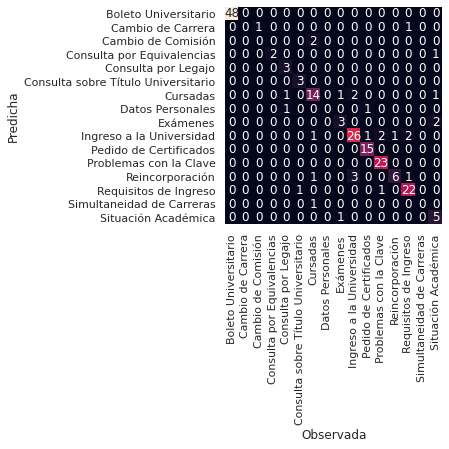

In [18]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import metrics #Importar el módulo metrics de scikit-learn

mat = metrics.confusion_matrix(test_df.labels, predictions)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

## 4. Persistencia del modelo

Se persiste el modelo en Google Drive:

In [12]:
!ls outputs/

checkpoint-100-epoch-1	config.json	   special_tokens_map.json  vocab.txt
checkpoint-200-epoch-2	eval_results.txt   tokenizer_config.json
checkpoint-300-epoch-3	model_args.json    tokenizer.json
checkpoint-400-epoch-4	pytorch_model.bin  training_args.bin


In [13]:
GUARDAR_DRIVE = False

if GUARDAR_DRIVE:
  import shutil
  from google.colab import drive

  shutil.make_archive('outputs', 'zip', 'outputs')
  drive.mount('drive')
  !cp outputs.zip "drive/My Drive/50jaiio_modelos/"

## 5. Análisis del error

Genero un dataframe con el accuracy por clase y el _count_ de test:

In [23]:
df_error = pd.DataFrame()
df_error['clases'] = pd.Series(etiquetas)

# Calculo el accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count'] = mat.sum(axis=1)

df_error

,clases,accuracy,count
0,Boleto Universitario,1.000000,48
1,Cambio de Carrera,0.000000,2
2,Cambio de Comisión,0.000000,2
3,Consulta por Equivalencias,0.666667,3
4,Consulta por Legajo,1.000000,3
5,Consulta sobre Título Universitario,1.000000,3
6,Cursadas,0.736842,19
7,Datos Personales,0.000000,2
8,Exámenes,0.600000,5
9,Ingreso a la Universidad,0.787879,33


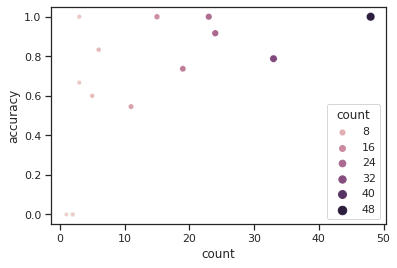

In [24]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.scatterplot(data=df_error, x="count", y="accuracy", hue="count", size="count")

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05